In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy
import torch

from concepts import concept_instances
from probing import train_probe
from utils import load_game_data, load_q_network_device

In [3]:
game_data = load_game_data()
q_network, device = load_q_network_device()
q_network.to('cpu')

layer = '5'
hyperparams = {
    'lr': 0.0005,
    'batch_size': 64,
    'epochs': 200,
    'lambda_l1': 0.00001,
    'patience': 5
}

actions = ['None', 'Fire', 'Right', 'Left']

In [4]:
concept_q_improvement = {} # does concept improve max(q value)?
concept_action_improvement = {} 
concept_cavs = {} # save probe for each concept
best_action_ratio = {a:[] for a in actions} # for each action, how often was this action improved the most by adding concept?

In [5]:
# find next layer
for idx, (name, l) in enumerate(q_network.network.named_children()):
    if name == layer:
        break

In [6]:
for concept in concept_instances.values():
    # get cav for concept
    probe, score = train_probe(game_data, q_network, concept, layer, hyperparams)
    print(f'{concept.name}: {score}')
    cav = probe[1].weight
    concept_cavs[concept.name] = cav

    # get q values and test activations
    q_values, acts_dict = q_network(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]
    acts = acts.reshape(acts.shape[0], -1)
    
    # pertubate a tiny bit of cav and see how q values change
    acts_pertubated = torch.tensor(acts + (0.0001 * cav), dtype=torch.float32)

    # forward activations from given layer
    q_values_new = q_network.network[idx + 1:](acts_pertubated)
    
    # how often does max increase?
    q_values_diff = q_values_new - q_values
    max_diff = q_values_new.max(dim=1)[0] - q_values.max(dim=1)[0] # if we did the best action with old and new q values
    improvement_ratio = sum(max_diff > 0) / len(max_diff) # how often is the new q value better than the old one?
    concept_q_improvement[concept.name] = improvement_ratio.item()

    # Which action improved most?
    max_indices = q_values_diff.argmax(dim=1)
    most_improvement_counter = {i: sum(max_indices == i) / len(q_values_diff) for i in range(4)}
    for i, action in enumerate(actions):
        action_name = actions[i]
        best_action_ratio[action_name].append(most_improvement_counter[i].item())

random (b): -0.00390625


/tmp/ipykernel_16147/509291581.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acts_pertubated = torch.tensor(acts + (0.0001 * cav), dtype=torch.float32)


all lives (b): 0.9744318181818182
last life (b): 0.9965277777777778
reward (b): 0.7392857074737549
ball collision (b): 0.7971912936160439
ball low (b): 0.9671052631578947
ball left paddle (b): 0.8411458313465119
ball right paddle (b): 0.8178670343599821
ball same x paddle (b): 0.6020833353201548
ball distance paddle: 0.9206608235836029
ball y: 0.8991185575723648
ball y next: 0.8718968232472738
ball x: 0.9309933806459109
ball x next: 0.9124136020739874
lives: 0.9944862549503645
x diff: 0.7230857933561007
frames until collision horizontal: 0.35653572777907055
frames until collision vertical: 0.3689827074607213
paddle x: 0.9604250366489092
ball speed horizontal: 0.6774082904060682
ball speed vertical: 0.5877563332517942
game steps: 0.9965348492066065
bricks hit: 0.9974127039313316


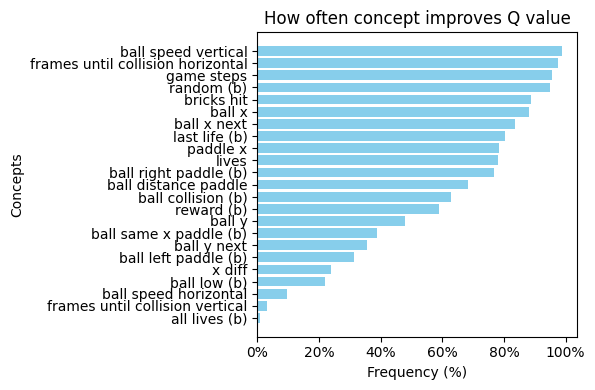

In [7]:
sorted_data = sorted(concept_q_improvement.items(), key=lambda x: x[1], reverse=True)
# Extracting keys and values, and converting values to percentages
keys = [item[0] for item in sorted_data]
values = [item[1] * 100 for item in sorted_data]

# Creating the bar chart
plt.figure(figsize=(6, 4))
plt.barh(keys, values, color='skyblue')
plt.xlabel('Frequency (%)')
plt.ylabel('Concepts')
plt.title('How often concept improves Q value')
plt.gca().invert_yaxis()  # To display the largest values at the top
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
plt.gca().xaxis.set_ticks(range(0, 101, 20))
plt.tight_layout()
plt.show()

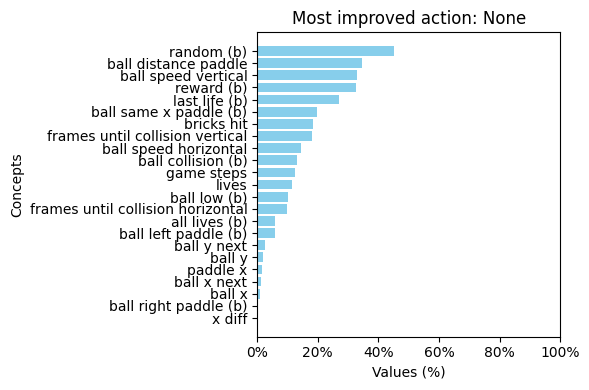

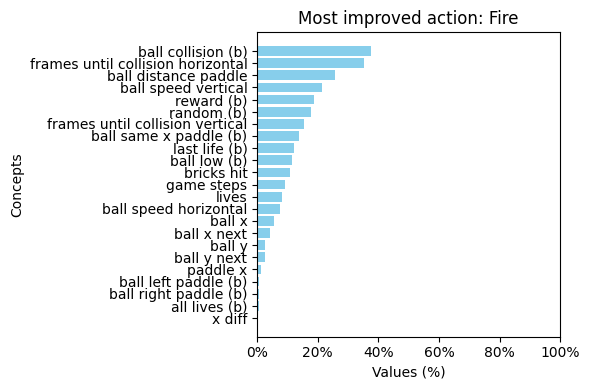

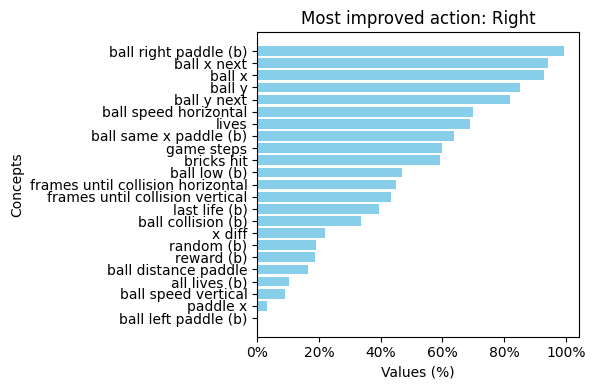

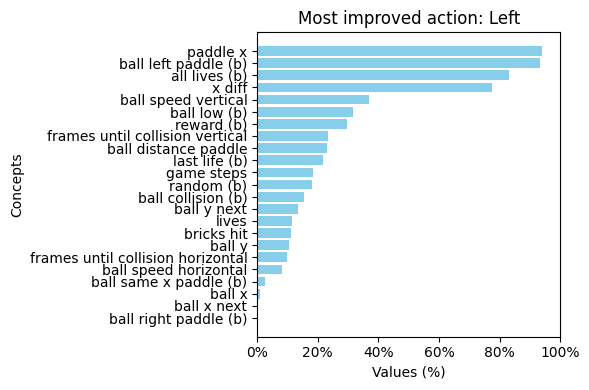

In [8]:
concept_names = list(concept_instances.keys())
for action_name, values in best_action_ratio.items():
    # Sort values and concept_names together in descending order
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    sorted_values = [values[i]*100 for i in sorted_indices]
    sorted_concept_names = [concept_names[i] for i in sorted_indices]
    
    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(sorted_concept_names, sorted_values, color='skyblue')
    plt.xlabel('Values (%)')
    plt.ylabel('Concepts')
    plt.title(f'Most improved action: {action_name}')
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    plt.gca().xaxis.set_ticks(range(0, 101, 20))
    plt.tight_layout()
    plt.show()

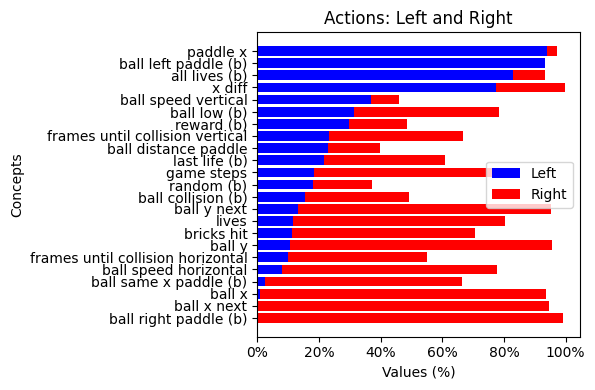

: 

In [9]:
left_values = best_action_ratio["Left"]
right_values = best_action_ratio["Right"]

# Sort values and concept_names based on "Left" in descending order
sorted_indices = sorted(range(len(left_values)), key=lambda k: left_values[k], reverse=True)
sorted_left_values = [left_values[i]*100 for i in sorted_indices]
sorted_right_values = [right_values[i]*100 for i in sorted_indices]
sorted_concept_names = [concept_names[i] for i in sorted_indices]

# Plotting the combined graph
plt.figure(figsize=(6, 4))
plt.barh(sorted_concept_names, sorted_left_values, color='blue', label='Left')
plt.barh(sorted_concept_names, sorted_right_values, color='red', left=sorted_left_values, label='Right')  # Stacking "Right" on top of "Left"
plt.xlabel('Values (%)')
plt.ylabel('Concepts')
plt.title('Actions: Left and Right')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
plt.gca().xaxis.set_ticks(range(0, 101, 20))
plt.legend()
plt.tight_layout()
plt.show()